In [1]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings(action= 'ignore')

## 1. Manipulações Iniciais

Etapa 1 - Carregamento

In [4]:
# Carregando os Dados Históricos
train_data = pd.read_csv('./air_system_previous_years.csv').replace(to_replace= 'na', value= np.nan)

In [6]:
# Transformando 'neg' para 0 (não evento) e 'pos' para 1 (evento)
train_data['class'] = train_data['class'].map({
    'neg' : 0,
    'pos' : 1
})

Etapa 2 -  Convertendo o data type dos dados de `object` para ``float``

In [7]:
train_data = train_data.astype(dtype= float).copy()
train_data['class'] = train_data['class'].astype(dtype= int).copy()

Etapa 3 - Separando o Target e removendo-o do dataframe principal
* Checar distribuição do target

In [9]:
y = train_data['class']

train_data = train_data.drop(columns=['class'])

In [32]:
# Checando a distribuição do target
y.value_counts(normalize= True).mul(100)

class
0    98.333333
1     1.666667
Name: proportion, dtype: float64

## 2. Isolation Forest

Isolation Forest é um modelo não supervisionado baseado em arvores de decisão. A ideia aqui é utilizar este algoritmo para criar uma feature adicional que ajude a identificar anomalias. A escolha se deu por conta do grande desbalanceamento da variável target (`class`).

Etapa 1 - Data Preparation
* Inputar missings no set inteiro
* Por ser um método baseado em árvores, não requer escalonamento das variáveis
* Modelo já inserido na Pipeline

In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# dp_IF: dataprep_IsolationForest
# Pegando a lista das variáveis numéricas
dp_IF_num_vars_list = train_data.select_dtypes(exclude= 'object').columns.to_list()

# Configurando o Pipeline para variáveis numéricas
dp_IF_num_pipeline = Pipeline([
    ('dp_IF_imputer', SimpleImputer(strategy= 'median')),
])

# Criando o Transformador
dp_IF_preprocessor = ColumnTransformer([
    ('dp_IF_num', dp_IF_num_pipeline, dp_IF_num_vars_list)
])

# Criando o Pipeline
IF_pipeline = Pipeline(
    steps= [
        ('dp_IF_preprocessor', dp_IF_preprocessor), # Aplica o pre-processamento
        ('IF_model', IsolationForest(random_state= 1, contamination= 0.016)) # Aplica o Isolation Forest
    ]
)

Etapa 2 - Aplicação do Pipeline
* Inputar missings no set inteiro
* Por ser um método baseado em árvores, não requer escalonamento das variáveis
* Salvando o artefato

In [13]:
# Ajustando aos dados originais
IF_pipeline = IF_pipeline.fit(train_data)

# Inserindo os scores de anomalia no conjunto de dados original
train_data['anomaly_scores'] = IF_pipeline.decision_function(train_data)

In [ ]:
with open('./artefatos/IsolationForest/pipeline.pkl', mode= 'wb') as file:
    pickle.dump(IF_pipeline, file)

## 3. Clustering

Etapa 1 - Criação do Pipeline
* Imputa a mediana nos dados numéricos faltantes
* Padroniza os dados
* Aplica o PCA, criando as componentes principais, capturando 80% da variância original dos dados

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# dp_PCA: dataprep_PrincipalComponentAnalysis

# Pegando a lista das variáveis numéricas
dp_PCA_num_vars_list = train_data.select_dtypes(exclude= 'object').columns.to_list()

# Configurando o Pipeline para variáveis numéricas
dp_PCA_num_pipeline = Pipeline([
    ('dp_PCA_imputer', SimpleImputer(strategy= 'median')),
    ('dp_PCA_scaler', StandardScaler())
])

# Criando o Transformador
dp_PCA_preprocessor = ColumnTransformer([
    ('dp_PCA_num', dp_PCA_num_pipeline, dp_PCA_num_vars_list)
])

# Criando o Pipeline
PCA_pipeline = Pipeline(
    steps= [
        ('dp_PCA_preprocessor', dp_PCA_preprocessor), # Aplica o pre-processamento
        ('PCA', PCA(n_components=0.80, random_state= 1)) # Aplica o PCA, capturando 80% da variancia
    ]
)

Etapa 2 - Aplicação do PCA
* Aplica a Pipeline
* Gera o dataframe reduzido que será utilizado no clustering
* Salvando o artefato

In [15]:
train_data_decomp = pd.DataFrame(PCA_pipeline.fit_transform(train_data))

In [ ]:
with open('./artefatos/GMM/PCA_pipeline.pkl', mode= 'wb') as file:
    pickle.dump(PCA_pipeline, file)

Etapa 3 - Configuração dos Parâmetros
* Aplicar o método da silhueta para encontrar o número ótimo de clusters
* Avaliar a melhor configuração através do menor BIC

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

Iteração número: 0 - Coeficiente de Silhueta: 0.8492708933310792
Iteração número: 1 - Coeficiente de Silhueta: 0.7349953022972967
Iteração número: 2 - Coeficiente de Silhueta: 0.679545562409774
Iteração número: 3 - Coeficiente de Silhueta: 0.6677705884726463
Iteração número: 4 - Coeficiente de Silhueta: 0.5490383745311288
Iteração número: 5 - Coeficiente de Silhueta: 0.4929798152154772
Iteração número: 6 - Coeficiente de Silhueta: 0.2718404227682196
Iteração número: 7 - Coeficiente de Silhueta: 0.27273217952788764


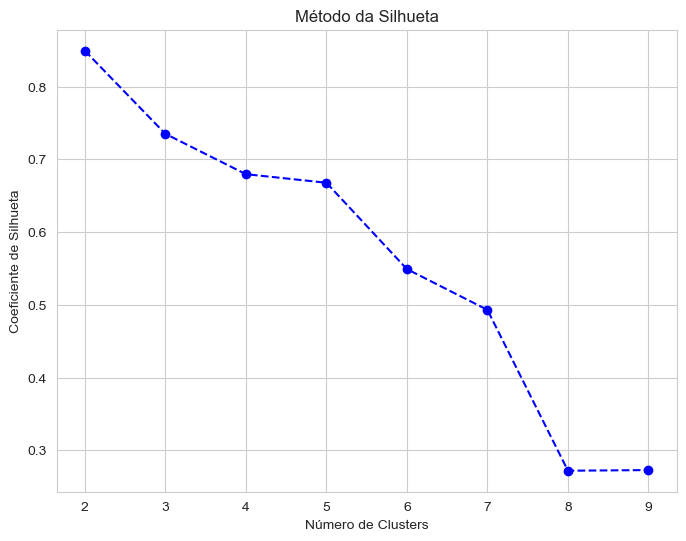

In [17]:
# Calcular a pontuação da silhueta para diferentes números de clusters
scores = []
i = 0
k_min = 2
k_max = 10

for i,n_clusters in enumerate(range(k_min, k_max)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto')
    cluster_labels = kmeans.fit_predict(train_data_decomp)

    silhouette_avg = silhouette_score(train_data_decomp, cluster_labels)
    scores.append(silhouette_avg)

    print(f'Iteração número: {i} - Coeficiente de Silhueta: {silhouette_avg}')

# Plotar o gráfico do método da silhueta
plt.figure(figsize=(8, 6))
plt.plot(range(k_min, k_max), scores, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta')
plt.title('Método da Silhueta')
plt.xticks(range(k_min, k_max))
plt.grid(True)
plt.show()

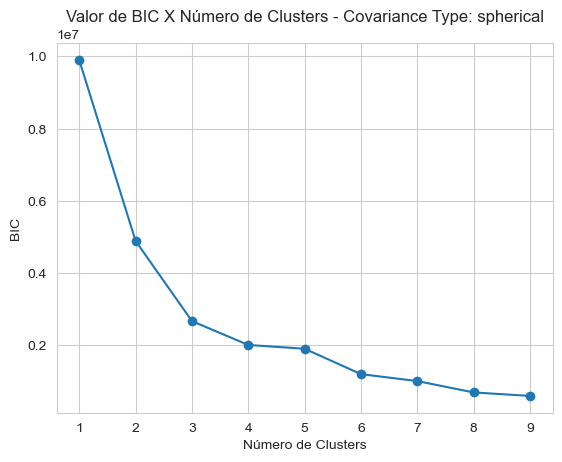

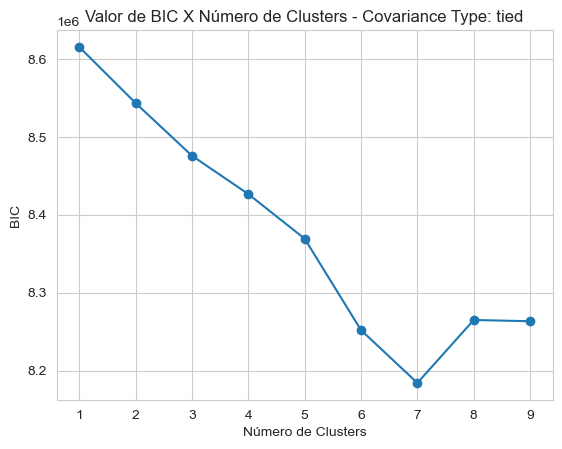

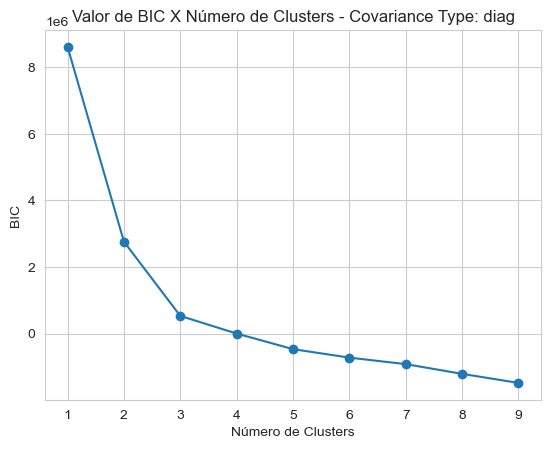

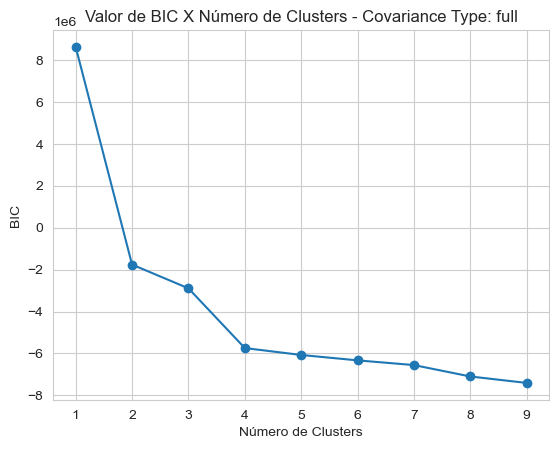

Melhor configuração: ('full', 9)
Menor BIC: -7402984.489155403


In [18]:
n_components = range(1, 10)
covariance_type = ['spherical', 'tied', 'diag', 'full']
best_bic = float('inf')  # Inicialize com um valor infinito
best_config = None
bic_scores = []


for cov in covariance_type:
    hist = []
    for n_comp in n_components:
        gmm = GaussianMixture(n_components=n_comp, covariance_type=cov, random_state=1)
        gmm.fit(train_data_decomp)
        bic_score = gmm.bic(train_data_decomp)
        bic_scores.append((cov, n_comp, bic_score))
        hist.append(bic_score)

        if bic_score < best_bic:
            best_bic = bic_score
            best_config = (cov, n_comp)
    
    plt.plot(n_components, hist, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('BIC')
    plt.title(f'Valor de BIC X Número de Clusters - Covariance Type: {cov}')
    plt.show()


print("Melhor configuração:", best_config)
print("Menor BIC:", best_bic)

> Embora com o método da Silhueta + KMeans o número ótimo de clusters sejam 2 ou 3, e isto traz certa facilidade para interpretação e insights, a configuração com 9 clusters utilizando o GMM possui um equilibrio melhor de complexidade x generalização, que será importante para as próximas etapas de construção do modelo.

Etapa 4 - Modelagem
* Aplicar o GMM utilizando a melhor configuração encontrada
* Salvando o artefato

In [23]:
# Inicializar o modelo de Mistura Gaussiana
gmm = GaussianMixture(n_components=best_config[1], covariance_type=best_config[0], random_state=1)

# Ajustar o modelo aos dados com parâmetros de inicialização específicos
gmm.fit(train_data_decomp)

# Gerando os clusters para cada observação e inserindo-os na base de dados original
train_data['cluster'] = gmm.predict(train_data_decomp)

In [ ]:
with open('./artefatos/GMM/GMM_model.pkl', mode= 'wb') as file:
    pickle.dump(gmm, file)

Etapa 5 - Visualizar os Clusters
* Como é a distribuição das classes dentro de cada cluster?

In [24]:
class_cluster = pd.DataFrame(data= {'class': y, 'cluster': train_data['cluster']})
event_rate_by_cluster = class_cluster.groupby(['cluster'], as_index= False).agg({'class' : 'mean'})

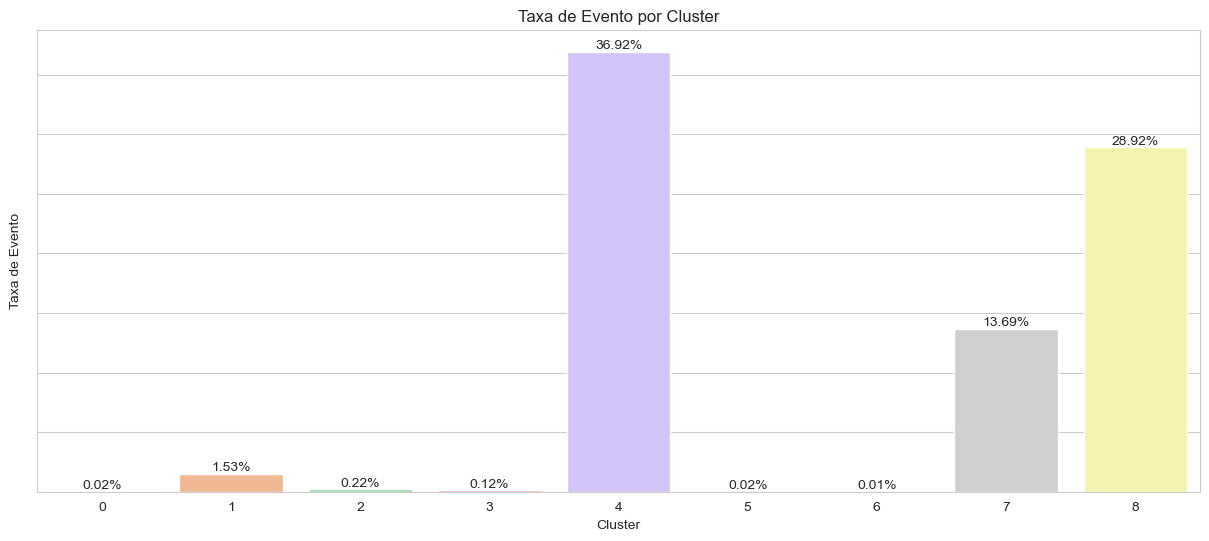

In [25]:
plt.figure(figsize=(15, 6))

sns.barplot(x="cluster", y="class", data= event_rate_by_cluster, palette=sns.color_palette('pastel'))

plt.title("Taxa de Evento por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Taxa de Evento")


# Adicionando os valores das taxas de rotatividade nas barras
for i, taxa in enumerate(event_rate_by_cluster['class'].values):
    plt.text(i, taxa, '{:.2f}%'.format(taxa * 100), ha='center', va='bottom', fontsize=10)

plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

> Dos 7 clusters gerados, podemos considerar que 4 deles não possuem qualquer taxa de evento significativa. Utilizando esses clusters como variáveis para o modelo, podemos ajudar os modelos de classificação a identificarem melhor os eventos.

Etapa 6 - Serialização
* Salvar a base final em .pkl

In [26]:
# Juntado o target na base
abt = pd.concat(
    objs= [train_data, y],
    axis= 1
)

# Transformando cluster em object
abt[['cluster']] = abt[['cluster']].astype('object')

with open('./artefatos/ABT/abt.pkl', mode= 'wb') as f:

    pickle.dump(abt, f)